# Chest X-Ray Abnormality Detection (Multi-Label CNN)

KENDALL MCNEIL, November 2023

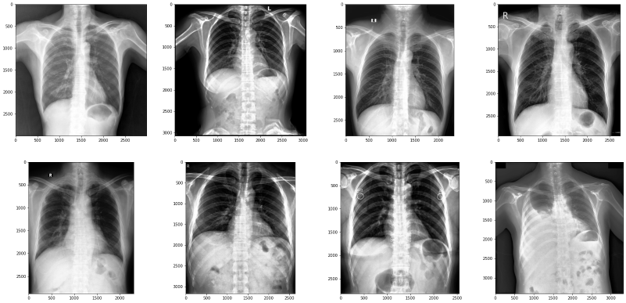

OBJECTIVE & METHODOLOGY: The chest x-ray is one of the most challenging to interpret, which can result in misdiagnosis even for seasoned healthcare providers. Building a strong convolutional neural network (CNN) to detect common thoracic lung diseases in chest x-rays would improve diagnostic accuracy for patients and ultimately save lives through early and accurate detection. The CNN will act as an automated system to support radiologists as a second opinion in reviewing chest x-rays for abnormalities. The work product will alleviate the stress of busy doctors and healthcare providers while also providing patients with a more accurate and efficient diagnosis. The objective, therefore, is to detect a variety (14 total) of common thoracic lung abnormalities in chest x-rays by building an AI system using a Convolutional Neural Network (CNN). The multi-label neural network image classification model was designed using Tensorflow.

AUDIENCES: The general target audience for the project is the healthcare industry. The more specific presentation audience is Vingroup Big Data Institute (VinBigData) that is working to build large-scale and high-precision medical imaging solutions based on the latest advancements in AI to facilitate efficient clinical workflows.

DATA: VinBigData has provided a dataset of 18,000 CXR scans dicom images labeled by a panel of experienced radiologists for the presence of 14 common thoracic abnormalities: aortic enlargement, atelectasis, calcification, cardiomegaly, consolidation, ILD, infiltration, lung opacity, nodule/mass, other lesion, pleural effusion, pleural thickening, pneumothorax, and pulmonary fibrosis. The dataset was created by assembling de-identified chest X-ray studies provided by two hospitals in Vietnam: the Hospital 108 and the Hanoi Medical University Hospital.

# A. Imports and Setup

In [6]:
cd

C:\Users\Jackson


In [7]:
cd Documents\flatiron\CAPSTONE\Chest-X-Ray-Abnormality-Detection-Multi-Label-CNN\data

C:\Users\Jackson\Documents\flatiron\CAPSTONE\Chest-X-Ray-Abnormality-Detection-Multi-Label-CNN\data


In [8]:
#basic imports 
import numpy as np
import pandas as pd
import os
import shutil
import random
import glob
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
import joblib

#tensorflow imports for CNN image classification project 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.models import load_model

#additional plotting imports
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

First, let's read in the data. Then let's store the full dataset under "original df" then create a dataframe with only image and class ID

In [9]:
original_df = pd.read_csv('train.csv')
df = original_df[['image_id','class_id']]

# B. Data Cleaning

Let's create a legend for the class names and class ids.

In [10]:
class_df = pd.DataFrame({'Number': list(range(15)),
    'Class_Name': ['Aortic enlargement','Atelectasis','Calcification','Cardiomegaly','Consolidation','ILD',
    'Infiltration','Lung Opacity','Nodule/Mass','Other lesion','Pleural effusion','Pleural thickening','Pneumothorax',
    'Pulmonary fibrosis','No finding']})
class_df

,Number,Class_Name
0,0,Aortic enlargement
1,1,Atelectasis
2,2,Calcification
3,3,Cardiomegaly
4,4,Consolidation
5,5,ILD
6,6,Infiltration
7,7,Lung Opacity
8,8,Nodule/Mass
9,9,Other lesion


How many of each class are in our dataset?

In [11]:
class_counts_df = original_df['class_name'].value_counts()
class_counts_df

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

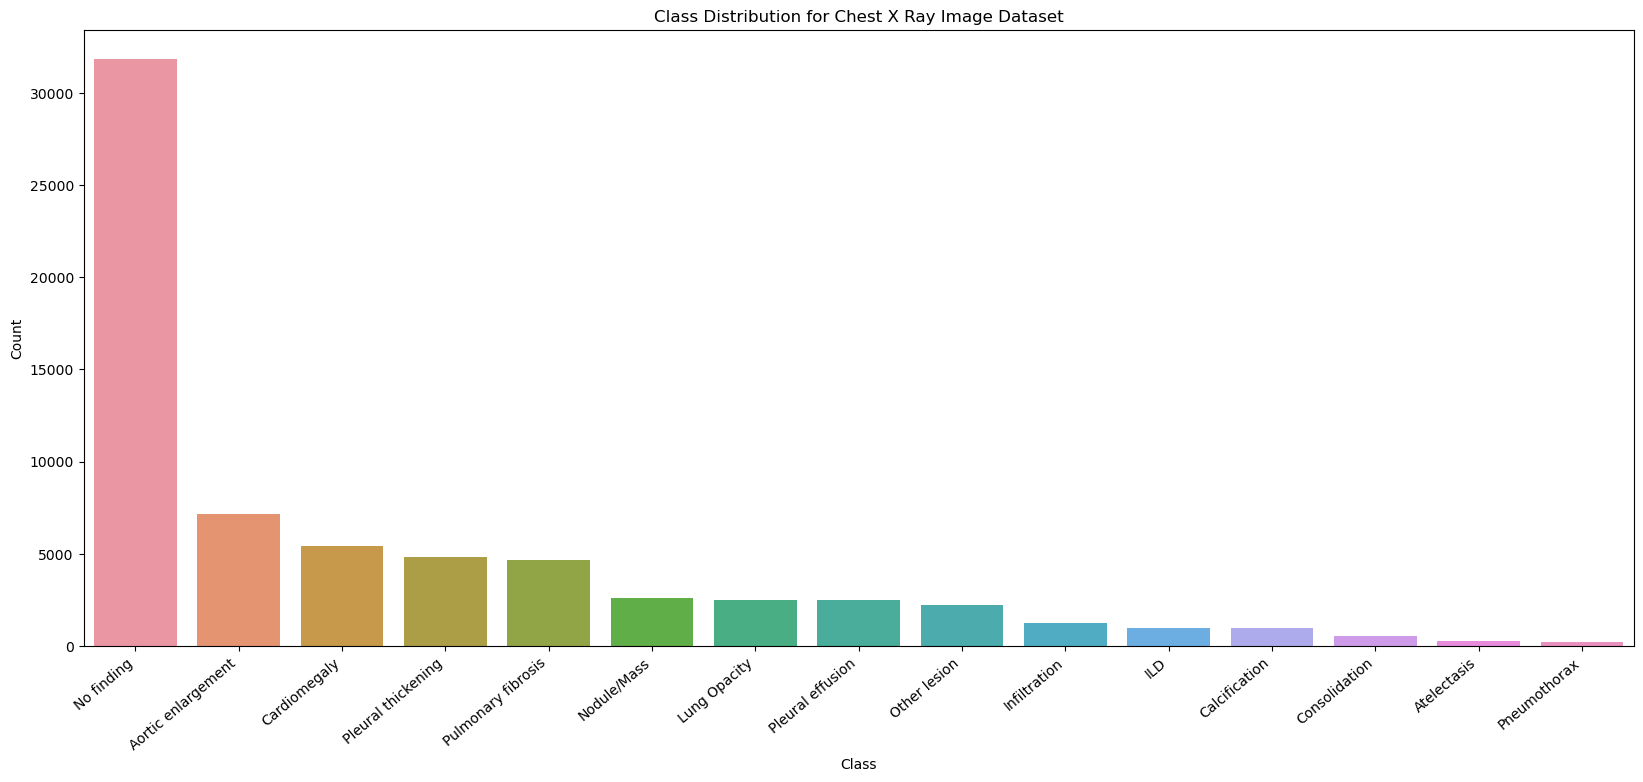

In [12]:
fig, ax = plt.subplots(figsize=(20,8))

sns.barplot(x=class_counts_df.index, y=class_counts_df)
ax.set_title('Class Distribution for Chest X Ray Image Dataset')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

The distribution looks okay. There are no classes with less than 100 samples. There may be a class imbalance that may rear its head later given that such a large amount of the data points fall into the 'no finding' class. Let's peak into image ID value counts.

In [13]:
df['image_id'].value_counts().head()

03e6ecfa6f6fb33dfeac6ca4f9b459c9    57
fa109c087e46fe1ea27e48ce6d154d2f    52
e31be972e181987a8600a8700c1ebe88    48
6d5acf3f8a973a26844d617fffe72998    46
3a302fbbbf3364aa1a7731b59e6b98ec    46
Name: image_id, dtype: int64

That's odd. Some image IDs have over 50 counts. Let's check on duplicates.

In [14]:
df.duplicated().sum()

41943

Wow. There are a lot of duplicates. Let's drop them.

In [15]:
df = df.drop_duplicates()
df['image_id'].value_counts().head(20)

8573fa95ec3defbe2dec45d85a5093a1    10
7d0e636b3ef2ccbb0c67b3243a1478ce    10
7e9efb8ee0bae7af280f5ea091f8d245    10
0c6a7e3c733bd4f4d89443ca16615fc6    10
9e9cc9d084546cb6d7f7ddba63411a81     9
c42997b00e59f4523788aa9fbe1f7526     9
e9954e6e3b2d0c5bf990a519c0ba5abe     9
54e6184c63c75a9695d7effc17969ad0     9
a4fc9faa46af26c5fc462772d88d0af3     9
d0043062cebce85f2487407bc033d405     9
8ac12a69ad57ca73535e04b6cfba5edb     9
2e285b95faad220e17e6cbfbe514733e     9
26585204e3c296a3b105bd5bd1c537ee     9
ae3382840414ce4de46c3827674b9709     9
5673fae597c1b5218f79eead1f413da6     9
54f9194379210945be0ed72fac357456     9
6e4915e84e38de5d90efe0ecfd8f2cf6     9
734bbd50e6a2265ae0092510852c9c24     9
41cee81dbe9886a56b6c3ee56fb23448     9
eca27ff9495044fbcd347ee51a8f1187     9
Name: image_id, dtype: int64

Much better. Let's also check that there are no duplicate photos in the images folder just to be sure.

In [16]:
folder_path = 'images'

#create a dictionary to store encountered file names.
file_names = {}

#iterate through the files in the folder.
for filename in os.listdir(folder_path):
    #check if the file is a regular file (not a subdirectory).
    if os.path.isfile(os.path.join(folder_path, filename)):
        #check if the file name has been encountered before.
        if filename in file_names:
            print(f'Duplicate file name: {filename}')
            print(f'First occurrence: {file_names[filename]}')
            print(f'Second occurrence: {os.path.join(folder_path, filename)}')
        else:
            #store the file name and its full path for future reference.
            file_names[filename] = os.path.join(folder_path, filename)

Great. There are no duplicate photos.

# C. Data Preprocessing

It is worth mentioning that the data provided did not have labeled targets (likely because it is an active competition). Therefore, we will use the 15,000 images in the train folder and take a subset of that set for testing and validation (step G). In step F, we will use 12500 images for training and 2500 images for testing - a 17/83% split. 
In step G, we will use 12500 images for training, 2000 images for testing, and 500 for validation - 83/13/3% split.

We need to perform additional data preprocessing before utilizing Tensorflow. There are multiple ways to input our data into Tensorflow's ImageDataGenerator and I attempted both: a column with a list of classes and one hot encoded columns. The former proved to be more a more efficient process. To test out both, let's create a final dataframe. 

Currently, there are multiple rows for each image that falls into multiple classes (i.e. - image ID listed 3 times if it has 3 classes). To fix this for our ImageDataGenerator, we need to groupby class ID, one hot encode the class IDs, and then merge the dataframes. That will create a final dataframe that has one row per image with one hot encoded classes. Let's also shuffle the dataframe images just in case because I will be selecting the first 12500 for the test set and the remaining 2500 for the test set (for step F). I will shuffle again when I split into train/test/val in step G. Last, let's add ".png" to all the image IDs so that our ImageDataGenerator can locate them efficiently.

In [17]:
#Step 1: group by image ID
grouped = df.groupby('image_id')['class_id'].apply(list).reset_index()

#Step 2: perform one-hot encoding
one_hot_encoded = pd.get_dummies(grouped['class_id'].apply(pd.Series).stack()).groupby(level=0).sum()

#Step 3: merge dataframes 
final_df = grouped.merge(one_hot_encoded, left_index=True, right_index=True)

#Step 4: shuffle the dataframe
final_df = final_df.sample(frac=1).reset_index(drop=True)

#Step 5: add ".png" to the image_ids 
final_df['image_id'] = final_df['image_id'] + '.png'

#the final_df DataFrame now contains one-hot encoded class labels for each image ID with one row per image
final_df

,image_id,class_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
0,f2458e4577d8b480f0380dcd93505b15.png,[14],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,8ae5be46f7b51d9cf7fbc3f7001a053a.png,[14],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1730d2ebd1cc96e9e5656cdf916ac7f8.png,"[8, 13, 9, 7, 3, 0, 4]",1,0,0,1,1,0,0,1,1,1,0,0,0,1,0
3,5d911ff93f3820e66d76ffe822300426.png,"[7, 2, 5, 6]",0,0,1,0,0,1,1,1,0,0,0,0,0,0,0
4,03a6078c0c12fb076b50ae017e590e19.png,"[3, 7, 13, 9, 0]",1,0,0,1,0,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,ddae224726cc363800e54cf9a2152831.png,[14],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
14996,bd7a9b6d834cfea362de14239e126dbd.png,[14],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
14997,ba498e9558a04900ce1ecf92cf20c5e7.png,[14],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
14998,8c75e7cff1d266d1d4f73187d7c1bbc2.png,"[3, 0]",1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Let's save off our new cleaned dataframe

In [18]:
#final_df.to_csv('./clean_dataframe.csv')

Now we're cookin' and ready for Tensorflow's ImageDataGenerator!

# D. ImageDataGenerator Setup 

In [19]:
train_datagen= ImageDataGenerator(rescale=1.0/255.0)
test_datagen= ImageDataGenerator(rescale=1.0/255.0)

final_columns = final_df.columns[2:].tolist()

train_generator = train_datagen.flow_from_dataframe(
    dataframe=final_df[:12500], directory=folder_path, x_col='image_id',
    y_col='class_id', seed=42, class_mode='categorical', color_mode='grayscale')

test_generator=test_datagen.flow_from_dataframe(
    dataframe=final_df[12500:], directory=folder_path, x_col='image_id', 
    y_col='class_id', seed=42, class_mode='categorical', batch_size=20, color_mode='grayscale')

Found 12500 validated image filenames belonging to 15 classes.
Found 2500 validated image filenames belonging to 15 classes.


Let's also create a function to evaluate the models moving forward. 

In [20]:
def evaluate(model):
    train_loss, train_accuracy = model.evaluate(train_generator)
    test_loss, test_accuracy = model.evaluate(test_generator)
    
    print(f'Train Loss: {train_loss}')
    print(f'Test Loss: {test_loss}')
    
    print('----------')
    
    
    print(f'Train Accuracy: {train_accuracy}')
    print(f'Test Accuracy: {test_accuracy}')

# E. Exploring Class Distributions

In [21]:
len(final_df['class_id'].value_counts())

2227

In [22]:
final_df['class_id'].value_counts(normalize=True).head(50)

[14]          0.707067
[0, 3]        0.023800
[3, 0]        0.023467
[0]           0.009467
[3]           0.006267
[0, 3, 11]    0.003467
[3, 0, 11]    0.003400
[13]          0.002533
[0, 11]       0.002533
[11, 3, 0]    0.002200
[0, 11, 3]    0.002133
[11, 0]       0.002067
[13, 11]      0.002000
[3, 11, 0]    0.001933
[11, 0, 3]    0.001800
[13, 0]       0.001400
[11, 13]      0.001333
[0, 3, 9]     0.001133
[0, 13]       0.001133
[10]          0.001000
[3, 0, 13]    0.001000
[0, 9]        0.000933
[8, 0]        0.000867
[3, 9]        0.000867
[13, 0, 3]    0.000867
[3, 13, 0]    0.000867
[8]           0.000867
[13, 3, 0]    0.000867
[3, 0, 7]     0.000867
[13, 6]       0.000800
[11]          0.000800
[0, 3, 13]    0.000800
[0, 3, 7]     0.000800
[0, 8]        0.000800
[10, 7]       0.000800
[9, 0, 3]     0.000733
[6, 13]       0.000667
[11, 10]      0.000667
[10, 11]      0.000667
[3, 0, 9]     0.000667
[9, 0]        0.000600
[13, 3]       0.000600
[0, 13, 3]    0.000600
[0, 9, 3]  

Wow! There are over 2000 output combinations of classes in our dataset. It is not surprising from the graph above that about 71% of the data points fall into the 'no finding' class and the rest of the class combinations are between 0-3%. This class distribution will be our baseline accuracy that our model needs to and will improve upon.

# F. Initial Model Building Without Image Augmentation (27 models)

Let's start with some simple Conv2D and MaxPooling2D layers.

In [23]:
model1 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(15, activation='sigmoid')
])

#compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 246016)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [133]:
#train the model⏰ this cell may take about a minute to run
model1.fit(train_generator, epochs=30, batch_size=64)

#evaluate the model
evaluate(model1)

Epoch 1/30
391/391 [==============================] - 505s 1s/step - loss: 0.0036 - accuracy: 0.8370
Epoch 2/30
391/391 [==============================] - 499s 1s/step - loss: 0.0040 - accuracy: 0.8368
Epoch 3/30
391/391 [==============================] - 494s 1s/step - loss: 0.0049 - accuracy: 0.8352
Epoch 4/30
391/391 [==============================] - 512s 1s/step - loss: 0.0047 - accuracy: 0.8395
Epoch 5/30
391/391 [==============================] - 504s 1s/step - loss: 0.0037 - accuracy: 0.8322
Epoch 6/30
391/391 [==============================] - 496s 1s/step - loss: 0.0030 - accuracy: 0.8370
Epoch 7/30
391/391 [==============================] - 487s 1s/step - loss: 0.0020 - accuracy: 0.8356
Epoch 8/30
391/391 [==============================] - 497s 1s/step - loss: 0.0035 - accuracy: 0.8317
Epoch 9/30
391/391 [==============================] - 496s 1s/step - loss: 0.0033 - accuracy: 0.8294
Epoch 10/30
391/391 [==============================] - 494s 1s/step - loss: 0.0030 - accura

Not a bad starting point, but we can see the model is overfit because the train accuracy is higher than the test accuracy. Let's add dropout and see how the model performs

In [24]:
model2 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout layer with a dropout rate of 0.5
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 246016)            0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [25]:
#train the model⏰ this cell may take about a minute to run
model2.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model2)

Epoch 1/10
391/391 [==============================] - 623s 2s/step - loss: 0.2534 - accuracy: 0.7018
Epoch 2/10
391/391 [==============================] - 563s 1s/step - loss: 0.1893 - accuracy: 0.7900
Epoch 3/10
391/391 [==============================] - 690s 2s/step - loss: 0.1739 - accuracy: 0.8173
Epoch 4/10
391/391 [==============================] - 794s 2s/step - loss: 0.1656 - accuracy: 0.8226
Epoch 5/10
391/391 [==============================] - 745s 2s/step - loss: 0.1543 - accuracy: 0.8336
Epoch 6/10
391/391 [==============================] - 757s 2s/step - loss: 0.1448 - accuracy: 0.8375
Epoch 7/10
391/391 [==============================] - 610s 2s/step - loss: 0.1357 - accuracy: 0.8424
Epoch 8/10
391/391 [==============================] - 592s 2s/step - loss: 0.1275 - accuracy: 0.8454
Epoch 9/10
391/391 [==============================] - 597s 2s/step - loss: 0.1194 - accuracy: 0.8510
Epoch 10/10
125/125 [==============================] - 59s 474ms/step - loss: 0.1926 - accu

Let's go back to a very first simple model and add an additional hidden layer.

In [40]:
model3 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),  #additional hidden layer
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 65536)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                4194368   
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 15)                495       
                                                                 
Total params: 4196943 (16.01 MB)
Trainable params: 4196943 (16.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
#train the model⏰ this cell may take about a minute to run
model3.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model3)

Epoch 1/10
391/391 [==============================] - 178s 448ms/step - loss: 0.3547 - accuracy: 0.6302
Epoch 2/10
391/391 [==============================] - 87s 222ms/step - loss: 0.2217 - accuracy: 0.7255
Epoch 3/10
391/391 [==============================] - 85s 217ms/step - loss: 0.2060 - accuracy: 0.7626
Epoch 4/10
391/391 [==============================] - 80s 204ms/step - loss: 0.1980 - accuracy: 0.7987
Epoch 5/10
391/391 [==============================] - 87s 222ms/step - loss: 0.1920 - accuracy: 0.8070
Epoch 6/10
391/391 [==============================] - 83s 214ms/step - loss: 0.1943 - accuracy: 0.8036
Epoch 7/10
391/391 [==============================] - 86s 219ms/step - loss: 0.1890 - accuracy: 0.8111
Epoch 8/10
391/391 [==============================] - 80s 205ms/step - loss: 0.1909 - accuracy: 0.8078
Epoch 9/10
391/391 [==============================] - 75s 191ms/step - loss: 0.1847 - accuracy: 0.8185
Epoch 10/10
125/125 [==============================] - 33s 263ms/step - 

This seems to be doing better. Let's checkout the learning rate. 

In [42]:
from tensorflow.keras.callbacks import LearningRateScheduler

#define a learning rate scheduler function
def lr_scheduler(epoch):
    # You can define your own learning rate schedule here.
    if epoch < 5:
        return 0.001  # Learning rate for the first 5 epochs
    else:
        return 0.0001  # Learning rate for the rest of the epochs

# Create a LearningRateScheduler callback
lr_schedule = LearningRateScheduler(lr_scheduler)

# Create the model
model4 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),  # Additional hidden layer
    layers.Dense(15, activation='sigmoid')
])

# Compile the model with the Adam optimizer
model4.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model4.summary()

# Train the model with the learning rate scheduler callback
model4.fit(train_generator, epochs=10, batch_size=64, callbacks=[lr_schedule])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 65536)             0         
                                                                 
 dense_9 (Dense)             (None, 64)                4194368   
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 15)                495       
                                                                 
Total params: 4196943 (16.01 MB)
Trainable params: 4196943 (16.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
391/391 [==============================] - 89s 225ms/step - loss: 0.3822 - accuracy: 0.6729 - lr: 0.0010
Epoch 2/10
391/391 [==========

In [43]:
evaluate(model4)

125/125 [==============================] - 15s 117ms/step - loss: 0.1749 - accuracy: 0.8060
Train Loss: 0.17570437490940094
Test Loss: 0.17492449283599854
----------
Train Accuracy: 0.811680018901825
Test Accuracy: 0.8059999942779541


Hmm... Let's add another hidden layer.

In [20]:
model5 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),  #additional hidden layer
    layers.Dense(32, activation='relu'),  #additional hidden layer
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 64)                4194368   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 15)                495       
                                                                 
Total params: 4197999 (16.01 MB)
Trainable params: 4197999 (16.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
#train the model⏰ this cell may take about a minute to run
model5.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model5)

Epoch 1/10
391/391 [==============================] - 267s 679ms/step - loss: 0.3049 - accuracy: 0.6598
Epoch 2/10
391/391 [==============================] - 186s 476ms/step - loss: 0.2158 - accuracy: 0.7437
Epoch 3/10
391/391 [==============================] - 135s 345ms/step - loss: 0.2028 - accuracy: 0.7615
Epoch 4/10
391/391 [==============================] - 130s 333ms/step - loss: 0.1970 - accuracy: 0.7756
Epoch 5/10
391/391 [==============================] - 120s 307ms/step - loss: 0.1953 - accuracy: 0.7674
Epoch 6/10
391/391 [==============================] - 147s 377ms/step - loss: 0.1883 - accuracy: 0.7750
Epoch 7/10
391/391 [==============================] - 135s 346ms/step - loss: 0.1910 - accuracy: 0.7686
Epoch 8/10
391/391 [==============================] - 131s 335ms/step - loss: 0.1863 - accuracy: 0.7694
Epoch 9/10
391/391 [==============================] - 156s 398ms/step - loss: 0.1846 - accuracy: 0.7710
Epoch 10/10
125/125 [==============================] - 49s 390ms

That didn't improve our model. Let's add more hidden layers just to see.

In [41]:
#lets add another hidden layer
model6 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),  #additional hidden layer
    layers.Dense(32, activation='relu'),  #additional hidden layer
    layers.Dense(32, activation='relu'),  #additional hidden layer
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 65536)             0         
                                                                 
 dense_9 (Dense)             (None, 64)                4194368   
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 15)                495       
                                                                 
Total params: 4199055 (16.02 MB)
Trainable params: 419

In [42]:
#train the model⏰ this cell may take about a minute to run
model6.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model6)

Epoch 1/10
391/391 [==============================] - 204s 518ms/step - loss: 0.2548 - accuracy: 0.7346
Epoch 2/10
391/391 [==============================] - 126s 324ms/step - loss: 0.2042 - accuracy: 0.7727
Epoch 3/10
391/391 [==============================] - 99s 252ms/step - loss: 0.2016 - accuracy: 0.7661
Epoch 4/10
391/391 [==============================] - 111s 283ms/step - loss: 0.1933 - accuracy: 0.7771
Epoch 5/10
391/391 [==============================] - 111s 283ms/step - loss: 0.1910 - accuracy: 0.7806
Epoch 6/10
391/391 [==============================] - 97s 248ms/step - loss: 0.1886 - accuracy: 0.7902
Epoch 7/10
391/391 [==============================] - 106s 271ms/step - loss: 0.1920 - accuracy: 0.7782
Epoch 8/10
391/391 [==============================] - 111s 284ms/step - loss: 0.1812 - accuracy: 0.7922
Epoch 9/10
391/391 [==============================] - 112s 285ms/step - loss: 0.1818 - accuracy: 0.7895
Epoch 10/10
125/125 [==============================] - 36s 291ms/s

Let's increase the neurons of our hidden layer.

In [43]:
model7 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(256, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model7.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 65536)             0         
                                                                 
 dense_14 (Dense)            (None, 64)                4194368   
                                                                 
 dense_15 (Dense)            (None, 256)               16640     
                                                                 
 dense_16 (Dense)            (None, 15)                3855      
                                                                 
Total params: 4214863 (16.08 MB)
Trainable params: 4214863 (16.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
#train the model⏰ this cell may take about a minute to run
model7.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model7)

Epoch 1/10
391/391 [==============================] - 124s 315ms/step - loss: 0.2727 - accuracy: 0.6964
Epoch 2/10
391/391 [==============================] - 128s 327ms/step - loss: 0.2146 - accuracy: 0.7543
Epoch 3/10
391/391 [==============================] - 136s 348ms/step - loss: 0.2042 - accuracy: 0.7794
Epoch 4/10
391/391 [==============================] - 121s 309ms/step - loss: 0.1970 - accuracy: 0.7854
Epoch 5/10
391/391 [==============================] - 123s 314ms/step - loss: 0.1917 - accuracy: 0.7872
Epoch 6/10
391/391 [==============================] - 118s 302ms/step - loss: 0.1875 - accuracy: 0.7910
Epoch 7/10
391/391 [==============================] - 111s 283ms/step - loss: 0.1864 - accuracy: 0.7930
Epoch 8/10
391/391 [==============================] - 106s 272ms/step - loss: 0.1862 - accuracy: 0.7976
Epoch 9/10
391/391 [==============================] - 108s 277ms/step - loss: 0.1851 - accuracy: 0.7978
Epoch 10/10
125/125 [==============================] - 41s 326ms

Looks like we are headed somewhere! Lets increase the number of neurons from our best performing model so far. 

In [45]:
model8 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),  # Increase the size of the first hidden layer
    layers.Dense(64, activation='relu'),   # Increase the size of the second hidden layer
    layers.Dense(32, activation='relu'),
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model8.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 65536)             0         
                                                                 
 dense_17 (Dense)            (None, 128)               8388736   
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 15)                495       
                                                                 
Total params: 8399567 (32.04 MB)
Trainable params: 8399567 (32.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
#train the model⏰ this cell may take about a minute to run
model8.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model8)

Epoch 1/10
391/391 [==============================] - 156s 393ms/step - loss: 0.3374 - accuracy: 0.6990
Epoch 2/10
391/391 [==============================] - 162s 415ms/step - loss: 0.2104 - accuracy: 0.7371
Epoch 3/10
391/391 [==============================] - 133s 341ms/step - loss: 0.2019 - accuracy: 0.7513
Epoch 4/10
391/391 [==============================] - 127s 324ms/step - loss: 0.1963 - accuracy: 0.7609
Epoch 5/10
391/391 [==============================] - 123s 315ms/step - loss: 0.1914 - accuracy: 0.7623
Epoch 6/10
391/391 [==============================] - 127s 325ms/step - loss: 0.1891 - accuracy: 0.7610
Epoch 7/10
391/391 [==============================] - 128s 327ms/step - loss: 0.1875 - accuracy: 0.7653
Epoch 8/10
391/391 [==============================] - 121s 308ms/step - loss: 0.1865 - accuracy: 0.7685
Epoch 9/10
391/391 [==============================] - 123s 314ms/step - loss: 0.1823 - accuracy: 0.7678
Epoch 10/10
125/125 [==============================] - 39s 310ms

Lets go back to the first simple model again and add an additional hidden layer.

In [47]:
model9 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),   # Additional hidden layer
    layers.Dense(64, activation='relu'),   # Additional hidden layer
    layers.Dense(32, activation='relu'),
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model9.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 65536)             0         
                                                                 
 dense_21 (Dense)            (None, 64)                4194368   
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 15)                495       
                                                                 
Total params: 4205263 (16.04 MB)
Trainable params: 420

In [48]:
#train the model⏰ this cell may take about a minute to run
model9.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model9)

Epoch 1/10
391/391 [==============================] - 127s 321ms/step - loss: 0.2556 - accuracy: 0.7173
Epoch 2/10
391/391 [==============================] - 121s 309ms/step - loss: 0.2098 - accuracy: 0.7647
Epoch 3/10
391/391 [==============================] - 149s 381ms/step - loss: 0.2019 - accuracy: 0.7779
Epoch 4/10
391/391 [==============================] - 179s 457ms/step - loss: 0.1914 - accuracy: 0.7981
Epoch 5/10
391/391 [==============================] - 168s 428ms/step - loss: 0.1919 - accuracy: 0.7821
Epoch 6/10
391/391 [==============================] - 169s 434ms/step - loss: 0.1913 - accuracy: 0.8030
Epoch 7/10
391/391 [==============================] - 187s 477ms/step - loss: 0.1842 - accuracy: 0.8072
Epoch 8/10
391/391 [==============================] - 197s 505ms/step - loss: 0.1861 - accuracy: 0.7915
Epoch 9/10
391/391 [==============================] - 658s 2s/step - loss: 0.1859 - accuracy: 0.7938
Epoch 10/10
125/125 [==============================] - 34s 274ms/st

Now, let's just try a whole bunch of variations to see what sticks.

In [49]:
model10 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model10.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model10.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 65536)             0         
                                                                 
 dense_26 (Dense)            (None, 64)                4194368   
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dense_28 (Dense)            (None, 32)                1056      
                                                                 
 dense_29 (Dense)            (None, 15)                495       
                                                                 
Total params: 4197999 (16.01 MB)
Trainable params: 4197999 (16.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
#train the model⏰ this cell may take about a minute to run
model10.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model10)

Epoch 1/10
391/391 [==============================] - 156s 395ms/step - loss: 0.2793 - accuracy: 0.6831
Epoch 2/10
391/391 [==============================] - 156s 400ms/step - loss: 0.2084 - accuracy: 0.7534
Epoch 3/10
391/391 [==============================] - 157s 402ms/step - loss: 0.1960 - accuracy: 0.7662
Epoch 4/10
391/391 [==============================] - 153s 392ms/step - loss: 0.1966 - accuracy: 0.7587
Epoch 5/10
391/391 [==============================] - 160s 408ms/step - loss: 0.1906 - accuracy: 0.7605
Epoch 6/10
391/391 [==============================] - 158s 403ms/step - loss: 0.1891 - accuracy: 0.7719
Epoch 7/10
391/391 [==============================] - 161s 411ms/step - loss: 0.1887 - accuracy: 0.7622
Epoch 8/10
391/391 [==============================] - 161s 413ms/step - loss: 0.1859 - accuracy: 0.7741
Epoch 9/10
391/391 [==============================] - 164s 419ms/step - loss: 0.1830 - accuracy: 0.7846
Epoch 10/10
125/125 [==============================] - 81s 647ms

In [51]:
model11 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(750, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model11.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model11.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 65536)             0         
                                                                 
 dense_30 (Dense)            (None, 64)                4194368   
                                                                 
 dense_31 (Dense)            (None, 750)               48750     
                                                                 
 dense_32 (Dense)            (None, 15)                11265     
                                                                 
Total params: 4254383 (16.23 MB)
Trainable params: 4254383 (16.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
#train the model⏰ this cell may take about a minute to run
model11.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model11)

Epoch 1/10
391/391 [==============================] - 826s 2s/step - loss: 0.2598 - accuracy: 0.7087
Epoch 2/10
391/391 [==============================] - 247s 632ms/step - loss: 0.2039 - accuracy: 0.7810
Epoch 3/10
391/391 [==============================] - 216s 553ms/step - loss: 0.2015 - accuracy: 0.7902
Epoch 4/10
391/391 [==============================] - 168s 429ms/step - loss: 0.1981 - accuracy: 0.8001
Epoch 5/10
391/391 [==============================] - 163s 417ms/step - loss: 0.1960 - accuracy: 0.8037
Epoch 6/10
391/391 [==============================] - 172s 441ms/step - loss: 0.1925 - accuracy: 0.8095
Epoch 7/10
391/391 [==============================] - 175s 448ms/step - loss: 0.1926 - accuracy: 0.8114
Epoch 8/10
391/391 [==============================] - 168s 429ms/step - loss: 0.1902 - accuracy: 0.8135
Epoch 9/10
391/391 [==============================] - 170s 434ms/step - loss: 0.1901 - accuracy: 0.8150
Epoch 10/10
125/125 [==============================] - 78s 626ms/st

In [54]:
model12 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(124, activation='relu'),
    layers.Dense(500, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model12.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model12.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 65536)             0         
                                                                 
 dense_33 (Dense)            (None, 124)               8126588   
                                                                 
 dense_34 (Dense)            (None, 500)               62500     
                                                                 
 dense_35 (Dense)            (None, 15)                7515      
                                                                 
Total params: 8196603 (31.27 MB)
Trainable params: 8196603 (31.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
#train the model⏰ this cell may take about a minute to run
model12.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model12)

Epoch 1/10
391/391 [==============================] - 123s 311ms/step - loss: 0.3401 - accuracy: 0.6997
Epoch 2/10
391/391 [==============================] - 122s 312ms/step - loss: 0.2128 - accuracy: 0.7627
Epoch 3/10
391/391 [==============================] - 118s 302ms/step - loss: 0.2003 - accuracy: 0.7854
Epoch 4/10
391/391 [==============================] - 118s 302ms/step - loss: 0.1963 - accuracy: 0.7810
Epoch 5/10
391/391 [==============================] - 115s 293ms/step - loss: 0.1900 - accuracy: 0.7842
Epoch 6/10
391/391 [==============================] - 119s 304ms/step - loss: 0.1920 - accuracy: 0.7846
Epoch 7/10
391/391 [==============================] - 118s 301ms/step - loss: 0.1872 - accuracy: 0.7878
Epoch 8/10
391/391 [==============================] - 113s 288ms/step - loss: 0.1893 - accuracy: 0.7997
Epoch 9/10
391/391 [==============================] - 116s 297ms/step - loss: 0.1863 - accuracy: 0.8132
Epoch 10/10
125/125 [==============================] - 20s 157ms

In [81]:
model13 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(150, activation='relu'),
    layers.Dense(256, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model13.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model13.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 65536)             0         
                                                                 
 dense_45 (Dense)            (None, 150)               9830550   
                                                                 
 dense_46 (Dense)            (None, 256)               38656     
                                                                 
 dense_47 (Dense)            (None, 15)                3855      
                                                                 
Total params: 9873061 (37.66 MB)
Trainable params: 9873061 (37.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [82]:
#train the model⏰ this cell may take about a minute to run
model13.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model13)

Epoch 1/10
391/391 [==============================] - 126s 320ms/step - loss: 0.3877 - accuracy: 0.6762
Epoch 2/10
391/391 [==============================] - 118s 302ms/step - loss: 0.2150 - accuracy: 0.7295
Epoch 3/10
391/391 [==============================] - 120s 307ms/step - loss: 0.2007 - accuracy: 0.7509
Epoch 4/10
391/391 [==============================] - 121s 310ms/step - loss: 0.1922 - accuracy: 0.7630
Epoch 5/10
391/391 [==============================] - 127s 324ms/step - loss: 0.1963 - accuracy: 0.7683
Epoch 6/10
391/391 [==============================] - 122s 313ms/step - loss: 0.1950 - accuracy: 0.7851
Epoch 7/10
391/391 [==============================] - 122s 312ms/step - loss: 0.1887 - accuracy: 0.7933
Epoch 8/10
391/391 [==============================] - 120s 307ms/step - loss: 0.1858 - accuracy: 0.7930
Epoch 9/10
391/391 [==============================] - 119s 303ms/step - loss: 0.1851 - accuracy: 0.7953
Epoch 10/10
125/125 [==============================] - 38s 302ms

In [83]:
model14 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(350, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model14.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model14.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 65536)             0         
                                                                 
 dense_48 (Dense)            (None, 64)                4194368   
                                                                 
 dense_49 (Dense)            (None, 350)               22750     
                                                                 
 dense_50 (Dense)            (None, 15)                5265      
                                                                 
Total params: 4222383 (16.11 MB)
Trainable params: 4222383 (16.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [84]:
#train the model⏰ this cell may take about a minute to run
model14.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model14)

Epoch 1/10
391/391 [==============================] - 110s 280ms/step - loss: 0.2677 - accuracy: 0.7044
Epoch 2/10
391/391 [==============================] - 104s 265ms/step - loss: 0.2092 - accuracy: 0.7566
Epoch 3/10
391/391 [==============================] - 102s 260ms/step - loss: 0.1981 - accuracy: 0.7646
Epoch 4/10
391/391 [==============================] - 100s 256ms/step - loss: 0.1945 - accuracy: 0.7684
Epoch 5/10
391/391 [==============================] - 10966s 28s/step - loss: 0.1911 - accuracy: 0.7728
Epoch 6/10
391/391 [==============================] - 107s 274ms/step - loss: 0.1918 - accuracy: 0.7755
Epoch 7/10
391/391 [==============================] - 81s 208ms/step - loss: 0.1897 - accuracy: 0.7742
Epoch 8/10
391/391 [==============================] - 82s 210ms/step - loss: 0.1940 - accuracy: 0.7785
Epoch 9/10
391/391 [==============================] - 81s 207ms/step - loss: 0.1857 - accuracy: 0.7882
Epoch 10/10
125/125 [==============================] - 34s 273ms/st

In [18]:
model15 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(200, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model15.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model15.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 64)                4194368   
                                                                 
 dense_1 (Dense)             (None, 200)               13000     
                                                                 
 dense_2 (Dense)             (None, 15)                3015      
                                                                 
Total params: 4210383 (16.06 MB)
Trainable params: 4210383 (16.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
#train the model⏰ this cell may take about a minute to run
model15.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model15)

Epoch 1/10
391/391 [==============================] - 216s 548ms/step - loss: 0.2700 - accuracy: 0.7094
Epoch 2/10
391/391 [==============================] - 144s 367ms/step - loss: 0.2059 - accuracy: 0.7684
Epoch 3/10
391/391 [==============================] - 99s 253ms/step - loss: 0.1994 - accuracy: 0.7846
Epoch 4/10
391/391 [==============================] - 83s 213ms/step - loss: 0.1978 - accuracy: 0.7794
Epoch 5/10
391/391 [==============================] - 81s 208ms/step - loss: 0.1912 - accuracy: 0.7855
Epoch 6/10
391/391 [==============================] - 82s 210ms/step - loss: 0.1880 - accuracy: 0.7872
Epoch 7/10
391/391 [==============================] - 86s 221ms/step - loss: 0.1939 - accuracy: 0.7818
Epoch 8/10
391/391 [==============================] - 86s 221ms/step - loss: 0.1885 - accuracy: 0.7933
Epoch 9/10
391/391 [==============================] - 84s 216ms/step - loss: 0.1861 - accuracy: 0.7977
Epoch 10/10
125/125 [==============================] - 34s 274ms/step -

In [20]:
model16 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='tanh'),
    layers.Dense(256, activation='tanh'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                4194368   
                                                                 
 dense_4 (Dense)             (None, 256)               16640     
                                                                 
 dense_5 (Dense)             (None, 15)                3855      
                                                                 
Total params: 4214863 (16.08 MB)
Trainable params: 4214863 (16.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
#train the model⏰ this cell may take about a minute to run
model16.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model16)

Epoch 1/10
391/391 [==============================] - 109s 277ms/step - loss: 0.2678 - accuracy: 0.7047
Epoch 2/10
391/391 [==============================] - 86s 219ms/step - loss: 0.2646 - accuracy: 0.7085
Epoch 3/10
391/391 [==============================] - 82s 211ms/step - loss: 0.2639 - accuracy: 0.7085
Epoch 4/10
391/391 [==============================] - 81s 207ms/step - loss: 0.2634 - accuracy: 0.7085
Epoch 5/10
391/391 [==============================] - 81s 207ms/step - loss: 0.2639 - accuracy: 0.7085
Epoch 6/10
391/391 [==============================] - 83s 213ms/step - loss: 0.2634 - accuracy: 0.7085
Epoch 7/10
391/391 [==============================] - 80s 205ms/step - loss: 0.2635 - accuracy: 0.7085
Epoch 8/10
391/391 [==============================] - 80s 204ms/step - loss: 0.2633 - accuracy: 0.7085
Epoch 9/10
391/391 [==============================] - 81s 207ms/step - loss: 0.2633 - accuracy: 0.7085
Epoch 10/10
125/125 [==============================] - 38s 307ms/step - 

In [22]:
model17 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='tanh'),
    layers.Dense(256, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model17.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model17.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 65536)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                4194368   
                                                                 
 dense_7 (Dense)             (None, 256)               16640     
                                                                 
 dense_8 (Dense)             (None, 15)                3855      
                                                                 
Total params: 4214863 (16.08 MB)
Trainable params: 4214863 (16.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
#train the model⏰ this cell may take about a minute to run
model17.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model17)

Epoch 1/10
391/391 [==============================] - 102s 257ms/step - loss: 0.2681 - accuracy: 0.7029
Epoch 2/10
391/391 [==============================] - 98s 250ms/step - loss: 0.2635 - accuracy: 0.7085
Epoch 3/10
391/391 [==============================] - 98s 251ms/step - loss: 0.2631 - accuracy: 0.7085
Epoch 4/10
391/391 [==============================] - 95s 242ms/step - loss: 0.2629 - accuracy: 0.7085
Epoch 5/10
391/391 [==============================] - 103s 263ms/step - loss: 0.2628 - accuracy: 0.7085
Epoch 6/10
391/391 [==============================] - 99s 252ms/step - loss: 0.2627 - accuracy: 0.7085
Epoch 7/10
391/391 [==============================] - 97s 249ms/step - loss: 0.2626 - accuracy: 0.7085
Epoch 8/10
391/391 [==============================] - 83s 213ms/step - loss: 0.2630 - accuracy: 0.7085
Epoch 9/10
391/391 [==============================] - 83s 212ms/step - loss: 0.2626 - accuracy: 0.7085
Epoch 10/10
125/125 [==============================] - 35s 280ms/step -

In [25]:
model18 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model18.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model18.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 65536)             0         
                                                                 
 dense_17 (Dense)            (None, 64)                4194368   
                                                                 
 dense_18 (Dense)            (None, 256)               16640     
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 dense_20 (Dense)            (None, 256)               65792     
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 dense_22 (Dense)            (None, 256)              

In [26]:
#train the model⏰ this cell may take about a minute to run
model18.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model18)

Epoch 1/10
391/391 [==============================] - 163s 412ms/step - loss: 0.2315 - accuracy: 0.7383
Epoch 2/10
391/391 [==============================] - 86s 219ms/step - loss: 0.2053 - accuracy: 0.7800
Epoch 3/10
391/391 [==============================] - 86s 221ms/step - loss: 0.1967 - accuracy: 0.7965
Epoch 4/10
391/391 [==============================] - 88s 224ms/step - loss: 0.1906 - accuracy: 0.8033
Epoch 5/10
391/391 [==============================] - 87s 223ms/step - loss: 0.1876 - accuracy: 0.7899
Epoch 6/10
391/391 [==============================] - 87s 222ms/step - loss: 0.1880 - accuracy: 0.7822
Epoch 7/10
391/391 [==============================] - 83s 213ms/step - loss: 0.1851 - accuracy: 0.7866
Epoch 8/10
391/391 [==============================] - 86s 220ms/step - loss: 0.1833 - accuracy: 0.7850
Epoch 9/10
391/391 [==============================] - 89s 228ms/step - loss: 0.1832 - accuracy: 0.7926
Epoch 10/10
125/125 [==============================] - 32s 255ms/step - 

In [27]:
model19 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model19.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model19.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 65536)             0         
                                                                 
 dense_25 (Dense)            (None, 64)                4194368   
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dense_29 (Dense)            (None, 64)                4160      
                                                                 
 dense_30 (Dense)            (None, 64)               

In [28]:
#train the model⏰ this cell may take about a minute to run
model19.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model19)

Epoch 1/10
391/391 [==============================] - 86s 214ms/step - loss: 0.2409 - accuracy: 0.7272
Epoch 2/10
391/391 [==============================] - 76s 196ms/step - loss: 0.2030 - accuracy: 0.7830
Epoch 3/10
391/391 [==============================] - 91s 233ms/step - loss: 0.1973 - accuracy: 0.7893
Epoch 4/10
391/391 [==============================] - 101s 258ms/step - loss: 0.1934 - accuracy: 0.7926
Epoch 5/10
391/391 [==============================] - 93s 238ms/step - loss: 0.1876 - accuracy: 0.8049
Epoch 6/10
391/391 [==============================] - 103s 263ms/step - loss: 0.1870 - accuracy: 0.8026
Epoch 7/10
391/391 [==============================] - 101s 257ms/step - loss: 0.1827 - accuracy: 0.7978
Epoch 8/10
391/391 [==============================] - 98s 251ms/step - loss: 0.1826 - accuracy: 0.7960
Epoch 9/10
391/391 [==============================] - 102s 261ms/step - loss: 0.1802 - accuracy: 0.7948
Epoch 10/10
125/125 [==============================] - 33s 269ms/step

Even though the model is not overfit, let's add in Batch Normalization and see what happens.

In [29]:
model20 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),  # Add batch normalization layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),  # Add batch normalization layer
    layers.Dense(15, activation='sigmoid')
])

# Compile the model
model20.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model20.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 65536)             0         
                                                                 
 dense_36 (Dense)            (None, 64)                4194368   
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense_37 (Dense)            (None, 256)               16640     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_38 (Dense)            (None, 15)               

In [30]:
#train the model⏰ this cell may take about a minute to run
model20.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model20)

Epoch 1/10
391/391 [==============================] - 168s 425ms/step - loss: 0.2970 - accuracy: 0.7114
Epoch 2/10
391/391 [==============================] - 157s 403ms/step - loss: 0.1820 - accuracy: 0.7737
Epoch 3/10
391/391 [==============================] - 127s 325ms/step - loss: 0.1744 - accuracy: 0.7804
Epoch 4/10
391/391 [==============================] - 153s 390ms/step - loss: 0.1683 - accuracy: 0.7897
Epoch 5/10
391/391 [==============================] - 156s 399ms/step - loss: 0.1636 - accuracy: 0.7897
Epoch 6/10
391/391 [==============================] - 152s 389ms/step - loss: 0.1626 - accuracy: 0.7878
Epoch 7/10
391/391 [==============================] - 106s 271ms/step - loss: 0.1605 - accuracy: 0.7901
Epoch 8/10
391/391 [==============================] - 83s 213ms/step - loss: 0.1585 - accuracy: 0.7894
Epoch 9/10
391/391 [==============================] - 85s 217ms/step - loss: 0.1549 - accuracy: 0.7920
Epoch 10/10
125/125 [==============================] - 37s 298ms/s

In [31]:
model21 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(67, activation='relu'),
    layers.Dense(260, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model21.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model21.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 65536)             0         
                                                                 
 dense_39 (Dense)            (None, 67)                4390979   
                                                                 
 dense_40 (Dense)            (None, 260)               17680     
                                                                 
 dense_41 (Dense)            (None, 15)                3915      
                                                                 
Total params: 4412574 (16.83 MB)
Trainable params: 4412574 (16.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
#train the model⏰ this cell may take about a minute to run
model21.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model21)

Epoch 1/10
391/391 [==============================] - 184s 463ms/step - loss: 0.2807 - accuracy: 0.7031
Epoch 2/10
391/391 [==============================] - 138s 352ms/step - loss: 0.2060 - accuracy: 0.7549
Epoch 3/10
391/391 [==============================] - 143s 365ms/step - loss: 0.1968 - accuracy: 0.7621
Epoch 4/10
391/391 [==============================] - 131s 336ms/step - loss: 0.2101 - accuracy: 0.7440
Epoch 5/10
391/391 [==============================] - 127s 325ms/step - loss: 0.1939 - accuracy: 0.7784
Epoch 6/10
391/391 [==============================] - 130s 333ms/step - loss: 0.1891 - accuracy: 0.7912
Epoch 7/10
391/391 [==============================] - 315s 806ms/step - loss: 0.1891 - accuracy: 0.7930
Epoch 8/10
391/391 [==============================] - 177s 452ms/step - loss: 0.1858 - accuracy: 0.7946
Epoch 9/10
391/391 [==============================] - 126s 323ms/step - loss: 0.1868 - accuracy: 0.7998
Epoch 10/10
125/125 [==============================] - 76s 611ms

In [33]:
model22 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(60, activation='relu'),
    layers.Dense(248, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model22.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model22.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 65536)             0         
                                                                 
 dense_42 (Dense)            (None, 60)                3932220   
                                                                 
 dense_43 (Dense)            (None, 248)               15128     
                                                                 
 dense_44 (Dense)            (None, 15)                3735      
                                                                 
Total params: 3951083 (15.07 MB)
Trainable params: 3951083 (15.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
#train the model⏰ this cell may take about a minute to run
model22.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model22)

Epoch 1/10
391/391 [==============================] - 141s 356ms/step - loss: 0.2513 - accuracy: 0.7294
Epoch 2/10
391/391 [==============================] - 893s 2s/step - loss: 0.2073 - accuracy: 0.7610
Epoch 3/10
391/391 [==============================] - 128s 328ms/step - loss: 0.1974 - accuracy: 0.7593
Epoch 4/10
391/391 [==============================] - 160s 408ms/step - loss: 0.1905 - accuracy: 0.7723
Epoch 5/10
391/391 [==============================] - 132s 338ms/step - loss: 0.1917 - accuracy: 0.7797
Epoch 6/10
391/391 [==============================] - 81s 207ms/step - loss: 0.1897 - accuracy: 0.7806
Epoch 7/10
391/391 [==============================] - 78s 200ms/step - loss: 0.1870 - accuracy: 0.8019
Epoch 8/10
391/391 [==============================] - 82s 210ms/step - loss: 0.1850 - accuracy: 0.7942
Epoch 9/10
391/391 [==============================] - 81s 207ms/step - loss: 0.1851 - accuracy: 0.7807
Epoch 10/10
125/125 [==============================] - 20s 158ms/step -

Let's continue to increase the nodes of the dense layer.

In [35]:
model23 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(76, activation='relu'),
    layers.Dense(278, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model23.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model23.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 65536)             0         
                                                                 
 dense_45 (Dense)            (None, 76)                4980812   
                                                                 
 dense_46 (Dense)            (None, 278)               21406     
                                                                 
 dense_47 (Dense)            (None, 15)                4185      
                                                                 
Total params: 5006403 (19.10 MB)
Trainable params: 5006403 (19.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
#train the model⏰ this cell may take about a minute to run
model23.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model23)

Epoch 1/10
391/391 [==============================] - 98s 247ms/step - loss: 0.2798 - accuracy: 0.7248
Epoch 2/10
391/391 [==============================] - 81s 208ms/step - loss: 0.2039 - accuracy: 0.7834
Epoch 3/10
391/391 [==============================] - 93s 239ms/step - loss: 0.1970 - accuracy: 0.7906
Epoch 4/10
391/391 [==============================] - 83s 213ms/step - loss: 0.1947 - accuracy: 0.7786
Epoch 5/10
391/391 [==============================] - 83s 211ms/step - loss: 0.1959 - accuracy: 0.7906
Epoch 6/10
391/391 [==============================] - 81s 208ms/step - loss: 0.1917 - accuracy: 0.8071
Epoch 7/10
391/391 [==============================] - 77s 197ms/step - loss: 0.1894 - accuracy: 0.8150
Epoch 8/10
391/391 [==============================] - 78s 201ms/step - loss: 0.1892 - accuracy: 0.8159
Epoch 9/10
391/391 [==============================] - 78s 200ms/step - loss: 0.1879 - accuracy: 0.8139
Epoch 10/10
125/125 [==============================] - 19s 150ms/step - l

In [37]:
model24 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(65, activation='relu'),
    layers.Dense(258, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model24.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model24.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 65536)             0         
                                                                 
 dense_48 (Dense)            (None, 65)                4259905   
                                                                 
 dense_49 (Dense)            (None, 258)               17028     
                                                                 
 dense_50 (Dense)            (None, 15)                3885      
                                                                 
Total params: 4280818 (16.33 MB)
Trainable params: 4280818 (16.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
#train the model⏰ this cell may take about a minute to run
model24.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model24)

Epoch 1/10
391/391 [==============================] - 127s 323ms/step - loss: 0.2932 - accuracy: 0.7102
Epoch 2/10
391/391 [==============================] - 88s 225ms/step - loss: 0.2084 - accuracy: 0.7526
Epoch 3/10
391/391 [==============================] - 83s 212ms/step - loss: 0.1960 - accuracy: 0.7734
Epoch 4/10
391/391 [==============================] - 76s 193ms/step - loss: 0.1938 - accuracy: 0.7689
Epoch 5/10
391/391 [==============================] - 76s 195ms/step - loss: 0.1890 - accuracy: 0.7787
Epoch 6/10
391/391 [==============================] - 77s 196ms/step - loss: 0.1916 - accuracy: 0.7754
Epoch 7/10
391/391 [==============================] - 76s 195ms/step - loss: 0.1859 - accuracy: 0.7931
Epoch 8/10
391/391 [==============================] - 77s 196ms/step - loss: 0.1888 - accuracy: 0.7870
Epoch 9/10
391/391 [==============================] - 78s 198ms/step - loss: 0.1838 - accuracy: 0.7926
Epoch 10/10
125/125 [==============================] - 17s 138ms/step - 

In [40]:
model25 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(256, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model25.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model25.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 65536)             0         
                                                                 
 dense_54 (Dense)            (None, 64)                4194368   
                                                                 
 dense_55 (Dense)            (None, 256)               16640     
                                                                 
 dense_56 (Dense)            (None, 15)                3855      
                                                                 
Total params: 4214863 (16.08 MB)
Trainable params: 4214863 (16.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
#train the model⏰ this cell may take about a minute to run
model25.fit(train_generator, epochs=20, batch_size=64)

#evaluate the model
evaluate(model25)

Epoch 1/20
391/391 [==============================] - 81s 205ms/step - loss: 0.2599 - accuracy: 0.7221
Epoch 2/20
391/391 [==============================] - 77s 196ms/step - loss: 0.1999 - accuracy: 0.7830
Epoch 3/20
391/391 [==============================] - 78s 199ms/step - loss: 0.2017 - accuracy: 0.7852
Epoch 4/20
391/391 [==============================] - 79s 202ms/step - loss: 0.1923 - accuracy: 0.7832
Epoch 5/20
391/391 [==============================] - 76s 194ms/step - loss: 0.1914 - accuracy: 0.7712
Epoch 6/20
391/391 [==============================] - 76s 193ms/step - loss: 0.1902 - accuracy: 0.7939
Epoch 7/20
391/391 [==============================] - 87s 223ms/step - loss: 0.1897 - accuracy: 0.8161
Epoch 8/20
391/391 [==============================] - 76s 195ms/step - loss: 0.1917 - accuracy: 0.8118
Epoch 9/20
391/391 [==============================] - 75s 192ms/step - loss: 0.1894 - accuracy: 0.8149
Epoch 10/20
391/391 [==============================] - 76s 194ms/step - l

This is looking better!

In [43]:
model26 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(256, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model26.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model26.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 65536)             0         
                                                                 
 dense_60 (Dense)            (None, 64)                4194368   
                                                                 
 dense_61 (Dense)            (None, 256)               16640     
                                                                 
 dense_62 (Dense)            (None, 15)                3855      
                                                                 
Total params: 4214863 (16.08 MB)
Trainable params: 4214863 (16.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
#train the model⏰ this cell may take about a minute to run
model26.fit(train_generator, epochs=15, batch_size=64)

#evaluate the model
evaluate(model26)

Epoch 1/15
391/391 [==============================] - 94s 237ms/step - loss: 0.2869 - accuracy: 0.6938
Epoch 2/15
391/391 [==============================] - 76s 195ms/step - loss: 0.2083 - accuracy: 0.7666
Epoch 3/15
391/391 [==============================] - 76s 193ms/step - loss: 0.1973 - accuracy: 0.7737
Epoch 4/15
391/391 [==============================] - 75s 192ms/step - loss: 0.1909 - accuracy: 0.7786
Epoch 5/15
391/391 [==============================] - 76s 194ms/step - loss: 0.1935 - accuracy: 0.7698
Epoch 6/15
391/391 [==============================] - 75s 191ms/step - loss: 0.1904 - accuracy: 0.7797
Epoch 7/15
391/391 [==============================] - 76s 194ms/step - loss: 0.1868 - accuracy: 0.7870
Epoch 8/15
391/391 [==============================] - 75s 191ms/step - loss: 0.1849 - accuracy: 0.7894
Epoch 9/15
391/391 [==============================] - 75s 193ms/step - loss: 0.1914 - accuracy: 0.8079
Epoch 10/15
391/391 [==============================] - 77s 197ms/step - l

Let's increase the epochs.

In [45]:
model27 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(256, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model27.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model27.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 65536)             0         
                                                                 
 dense_63 (Dense)            (None, 64)                4194368   
                                                                 
 dense_64 (Dense)            (None, 256)               16640     
                                                                 
 dense_65 (Dense)            (None, 15)                3855      
                                                                 
Total params: 4214863 (16.08 MB)
Trainable params: 4214863 (16.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
#train the model⏰ this cell may take about a minute to run
model27.fit(train_generator, epochs=150, batch_size=64)

#evaluate the model
evaluate(model27)

Epoch 1/150
391/391 [==============================] - 81s 206ms/step - loss: 0.2711 - accuracy: 0.7132
Epoch 2/150
391/391 [==============================] - 75s 191ms/step - loss: 0.2025 - accuracy: 0.7927
Epoch 3/150
391/391 [==============================] - 75s 193ms/step - loss: 0.1978 - accuracy: 0.7943
Epoch 4/150
391/391 [==============================] - 76s 195ms/step - loss: 0.1937 - accuracy: 0.7928
Epoch 5/150
391/391 [==============================] - 75s 192ms/step - loss: 0.1896 - accuracy: 0.7865
Epoch 6/150
391/391 [==============================] - 74s 190ms/step - loss: 0.1887 - accuracy: 0.7716
Epoch 7/150
391/391 [==============================] - 76s 194ms/step - loss: 0.1857 - accuracy: 0.7821
Epoch 8/150
391/391 [==============================] - 81s 208ms/step - loss: 0.1867 - accuracy: 0.7934
Epoch 9/150
391/391 [==============================] - 80s 204ms/step - loss: 0.1821 - accuracy: 0.7999
Epoch 10/150
391/391 [==============================] - 76s 193m

391/391 [==============================] - 75s 192ms/step - loss: 0.1755 - accuracy: 0.8302
Epoch 80/150
391/391 [==============================] - 75s 191ms/step - loss: 0.1742 - accuracy: 0.8366
Epoch 81/150
391/391 [==============================] - 77s 196ms/step - loss: 0.1784 - accuracy: 0.8288
Epoch 82/150
391/391 [==============================] - 75s 193ms/step - loss: 0.1750 - accuracy: 0.8406
Epoch 83/150
391/391 [==============================] - 75s 191ms/step - loss: 0.1728 - accuracy: 0.8385
Epoch 84/150
391/391 [==============================] - 76s 193ms/step - loss: 0.1725 - accuracy: 0.8406
Epoch 85/150
391/391 [==============================] - 77s 198ms/step - loss: 0.1757 - accuracy: 0.8316
Epoch 86/150
391/391 [==============================] - 77s 197ms/step - loss: 0.1730 - accuracy: 0.8412
Epoch 87/150
391/391 [==============================] - 76s 195ms/step - loss: 0.1744 - accuracy: 0.8357
Epoch 88/150
391/391 [==============================] - 75s 192ms/st

Model 27 is our best performing model so far with 150 epochs.

In [18]:
model28 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(256, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model28.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model28.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 64)                4194368   
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
 dense_2 (Dense)             (None, 15)                3855      
                                                                 
Total params: 4214863 (16.08 MB)
Trainable params: 4214863 (16.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
#train the model⏰ this cell may take about a minute to run
model28.fit(train_generator, epochs=170, batch_size=64)

#evaluate the model
evaluate(model28)

Epoch 1/170
391/391 [==============================] - 235s 598ms/step - loss: 0.2817 - accuracy: 0.7026
Epoch 2/170
391/391 [==============================] - 185s 474ms/step - loss: 0.2114 - accuracy: 0.7650
Epoch 3/170
391/391 [==============================] - 159s 407ms/step - loss: 0.2008 - accuracy: 0.7890
Epoch 4/170
391/391 [==============================] - 153s 392ms/step - loss: 0.1985 - accuracy: 0.7868
Epoch 5/170
391/391 [==============================] - 161s 412ms/step - loss: 0.1942 - accuracy: 0.7909
Epoch 6/170
391/391 [==============================] - 159s 407ms/step - loss: 0.1897 - accuracy: 0.7810
Epoch 7/170
391/391 [==============================] - 146s 373ms/step - loss: 0.1866 - accuracy: 0.7724
Epoch 8/170
391/391 [==============================] - 125s 319ms/step - loss: 0.1881 - accuracy: 0.7610
Epoch 9/170
391/391 [==============================] - 100s 257ms/step - loss: 0.1887 - accuracy: 0.7783
Epoch 10/170
391/391 [==============================] -

391/391 [==============================] - 74s 191ms/step - loss: 0.1725 - accuracy: 0.8379
Epoch 156/170
391/391 [==============================] - 75s 191ms/step - loss: 0.1686 - accuracy: 0.8446
Epoch 157/170
391/391 [==============================] - 77s 196ms/step - loss: 0.1879 - accuracy: 0.8167
Epoch 158/170
391/391 [==============================] - 4670s 12s/step - loss: 0.1717 - accuracy: 0.8370
Epoch 159/170
391/391 [==============================] - 64s 164ms/step - loss: 0.1758 - accuracy: 0.8322
Epoch 160/170
391/391 [==============================] - 88s 226ms/step - loss: 0.1758 - accuracy: 0.8314
Epoch 161/170
391/391 [==============================] - 86s 220ms/step - loss: 0.1675 - accuracy: 0.8470
Epoch 162/170
391/391 [==============================] - 84s 216ms/step - loss: 0.1724 - accuracy: 0.8370
Epoch 163/170
391/391 [==============================] - 83s 212ms/step - loss: 0.1690 - accuracy: 0.8446
Epoch 164/170
391/391 [==============================] - 87s

An increase in epochs did not seem to make a significant difference. I think we have found the sweet spot.

Image augmentation is a great way to improve our model by "adding more data" by slightly changing the original images by cropping, shifting, and rotating. For a dataset of 15,000, especially because we lost 3,000 that were not labeled, this may prove to be beneficial for our model. Let's give it a try and add a validation set while we are at it. 

# G. Image Augmentation and Validation Set (X models)

In [26]:
#shuffle the dataframe again
final_df = final_df.sample(frac=1).reset_index(drop=True)
final_df

,image_id,class_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
0,ad2667570c5af6029b7fdd5686fcdea3.png,[14],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2c08cec8a0877512a84a68aca6e2323d.png,[14],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,c242f77a49d3414341b9a611cd0d8321.png,[14],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,da32453a8f8cb3442c2cf786f5527601.png,[14],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,fa8fe6da7a88296fdd66fcfd8b2729d1.png,[14],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,55e6279aac033f9a68822a4f84d765fc.png,[14],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
14996,b8b8c9ae5afd3e8d2dbd5d69fa0f9378.png,"[5, 6, 11, 10, 9, 3, 0]",1,0,0,1,0,1,1,0,0,1,1,1,0,0,0
14997,58ab031cf2346b3a7b8fb32fb9ccd1c1.png,"[0, 11, 3]",1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
14998,7bf14801ba177b4d09cee3dd3e452973.png,[9],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [27]:
train_datagen= ImageDataGenerator(rescale=1.0/255.0)
test_datagen= ImageDataGenerator(rescale=1.0/255.0)
val_datagen= ImageDataGenerator(rescale=1.0/255.0)

final_columns = final_df.columns[2:].tolist()

train_generator = train_datagen.flow_from_dataframe(
    dataframe=final_df[:12500], directory=folder_path, x_col='image_id',
    y_col='class_id', seed=42, class_mode='categorical', color_mode='grayscale',
    #begin image augmentation
    horizontal_flip=True, height_shift_range=0.2, width_shift_range=0.2,
    rotation_range=45, brightness_range=[0.2,1], zoom_range=0.2)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=final_df[12500:14500], directory=folder_path, x_col='image_id', 
    y_col='class_id', seed=42, class_mode='categorical', batch_size=20, color_mode='grayscale')

val_generator=test_datagen.flow_from_dataframe(
    dataframe=final_df[14500:], directory=folder_path, x_col='image_id', 
    y_col='class_id', seed=42, class_mode='categorical', batch_size=20, color_mode='grayscale')

Found 12500 validated image filenames belonging to 15 classes.
Found 2000 validated image filenames belonging to 15 classes.
Found 500 validated image filenames belonging to 15 classes.


In [37]:
model1 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(15, activation='sigmoid')
])

#compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 246016)            0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [38]:
#train the model⏰ this cell may take about a minute to run
model1.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model1)

Epoch 1/10
391/391 [==============================] - 601s 2s/step - loss: 0.2065 - accuracy: 0.7532
Epoch 2/10
391/391 [==============================] - 521s 1s/step - loss: 0.1636 - accuracy: 0.7787
Epoch 3/10
391/391 [==============================] - 489s 1s/step - loss: 0.1404 - accuracy: 0.7927
Epoch 4/10
391/391 [==============================] - 496s 1s/step - loss: 0.1118 - accuracy: 0.8105
Epoch 5/10
391/391 [==============================] - 1083s 3s/step - loss: 0.0790 - accuracy: 0.8228
Epoch 6/10
391/391 [==============================] - 530s 1s/step - loss: 0.0481 - accuracy: 0.8396
Epoch 7/10
391/391 [==============================] - 536s 1s/step - loss: 0.0286 - accuracy: 0.8390
Epoch 8/10
391/391 [==============================] - 561s 1s/step - loss: 0.0166 - accuracy: 0.8366
Epoch 9/10
391/391 [==============================] - 566s 1s/step - loss: 0.0110 - accuracy: 0.8415
Epoch 10/10
100/100 [==============================] - 45s 447ms/step - loss: 0.5590 - acc

This model did slightly better than our model1 with no image augmentation. Let's add some Conv2D and MaxPooling2D. 

In [53]:
model2 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout layer with a dropout rate of 0.5
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 246016)            0         
                                                                 
 dense_17 (Dense)            (None, 128)              

In [56]:
#train the model⏰ this cell may take about a minute to run
model2.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model2)

Epoch 1/10
391/391 [==============================] - 503s 1s/step - loss: 0.2156 - accuracy: 0.7486
Epoch 2/10
391/391 [==============================] - 507s 1s/step - loss: 0.1825 - accuracy: 0.7825
Epoch 3/10
391/391 [==============================] - 521s 1s/step - loss: 0.1691 - accuracy: 0.7960
Epoch 4/10
391/391 [==============================] - 505s 1s/step - loss: 0.1579 - accuracy: 0.8101
Epoch 5/10
391/391 [==============================] - 4119s 11s/step - loss: 0.1482 - accuracy: 0.8174
Epoch 6/10
391/391 [==============================] - 482s 1s/step - loss: 0.1395 - accuracy: 0.8244
Epoch 7/10
391/391 [==============================] - 480s 1s/step - loss: 0.1293 - accuracy: 0.8391
Epoch 8/10
391/391 [==============================] - 484s 1s/step - loss: 0.1205 - accuracy: 0.8417
Epoch 9/10
391/391 [==============================] - 490s 1s/step - loss: 0.1132 - accuracy: 0.8491
Epoch 10/10
100/100 [==============================] - 40s 397ms/step - loss: 0.1794 - ac

Our best performing model in Step F without image augmentation was model27. Let's try that here.

In [18]:
model3 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(256, activation='relu'), 
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                4194368   
                                                                 
 dense_3 (Dense)             (None, 256)               16640     
                                                                 
 dense_4 (Dense)             (None, 15)                3855      
                                                                 
Total params: 4214863 (16.08 MB)
Trainable params: 4214863 (16.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
#train the model⏰ this cell may take about a minute to run
model3.fit(train_generator, epochs=150, batch_size=64)

#evaluate the model
evaluate(model3)

Epoch 1/150
391/391 [==============================] - 435s 1s/step - loss: 0.2292 - accuracy: 0.7163
Epoch 2/150
391/391 [==============================] - 269s 688ms/step - loss: 0.2064 - accuracy: 0.7450
Epoch 3/150
391/391 [==============================] - 157s 401ms/step - loss: 0.2033 - accuracy: 0.7745
Epoch 4/150
391/391 [==============================] - 151s 386ms/step - loss: 0.1995 - accuracy: 0.7812
Epoch 5/150
391/391 [==============================] - 155s 396ms/step - loss: 0.1932 - accuracy: 0.7924
Epoch 6/150
391/391 [==============================] - 158s 405ms/step - loss: 0.1921 - accuracy: 0.7824
Epoch 7/150
391/391 [==============================] - 154s 393ms/step - loss: 0.1907 - accuracy: 0.7862
Epoch 8/150
391/391 [==============================] - 153s 392ms/step - loss: 0.1936 - accuracy: 0.8094
Epoch 9/150
391/391 [==============================] - 158s 403ms/step - loss: 0.1912 - accuracy: 0.8124
Epoch 10/150
391/391 [==============================] - 15

In [28]:
model4 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(15, activation='sigmoid')
])

#compile the model
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 256)     147712    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 256)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 984064)            0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [ ]:
#train the model⏰ this cell may take about a minute to run
model4.fit(train_generator, epochs=10, batch_size=64)

#evaluate the model
evaluate(model4)

Epoch 1/10
391/391 [==============================] - 4212s 11s/step - loss: 0.2213 - accuracy: 0.7648
Epoch 2/10
391/391 [==============================] - 3862s 10s/step - loss: 0.1620 - accuracy: 0.7882
Epoch 3/10
391/391 [==============================] - 3623s 9s/step - loss: 0.1366 - accuracy: 0.7948
Epoch 4/10
391/391 [==============================] - 3569s 9s/step - loss: 0.1059 - accuracy: 0.8021
Epoch 5/10
386/391 [============================>.] - ETA: 51s - loss: 0.0686 - accuracy: 0.8221 

In [17]:
model5 = keras.Sequential([
    layers.Input(shape=(256, 256, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout layer with a dropout rate of 0.5
    layers.Dense(15, activation='sigmoid')
])

#compile the model 
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display the model summary
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 256)     73984     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 256)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 984064)            0         
                                                                 
 dense (Dense)               (None, 128)               1

In [ ]:
#train the model⏰ this cell may take about a minute to run
model5.fit(train_generator, epochs=20, batch_size=64)

#evaluate the model - down below. didn't run at first and this cell takes too long to re-run
evaluate(model5)

Epoch 1/20


# H. Selecting Final Model

Model 3 is our strongest so far with a simple model leveraging image augmentation. It has an accuracy rate of 85% on the training set and 84% on the testing set.

In [21]:
final_model = model3
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                4194368   
                                                                 
 dense_3 (Dense)             (None, 256)               16640     
                                                                 
 dense_4 (Dense)             (None, 15)                3855      
                                                                 
Total params: 4214863 (16.08 MB)
Trainable params: 4214863 (16.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now we will save off the model to be able to deploy it in streamlit so users can have access.

In [22]:
final_model.save('model.h5')
final_model = load_model('model.h5')